[View in Colaboratory](https://colab.research.google.com/github/vishal2develop/Kaggle-Competitions/blob/master/New-York-City-Taxi-Trip-Duration.ipynb)

# **New York City  Taxi Trip Duration Prediction Challenge**

** Installing the necessary dependency to import the dataset from our google drive to this python notebook**


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Data Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#setting parameters for matplot lip to make the figure fit our screen [16,10] is our screen size
plt.rcParams['figure.figsize']=[16,10]

import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb

%matplotlib inline
#making sure matplotlib fits inside the screen
plt.rcParams['axes.unicode_minus']=False



In [0]:
#Authenticate
auth.authenticate_user()
gauth=GoogleAuth()
gauth.credentials=GoogleCredentials.get_application_default()
drive=GoogleDrive(gauth)


In [45]:
#importing the training & testing data from Google drive
train_downloaded=drive.CreateFile({'id': '1-FMAlfiE9eNbidqRHByTokXwg7kvX1mT'})
train_downloaded.GetContentFile('train.csv')
test_downloaded=drive.CreateFile({'id': '1fX1vikjUc1AvVMAmlhWclhGa-eunlEvJ'})
test_downloaded.GetContentFile('test.csv')

#Loading the dataset using pandas
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

df_train.head(3)




,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [43]:
train_data=df_train.drop(['store_and_fwd_flag'],axis=1)
test_data=df_test.drop(['store_and_fwd_flag'],axis=1)
#train_data.head()
test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890


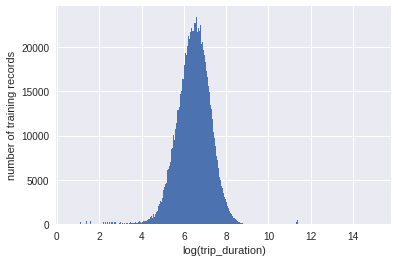

In [46]:
#Data preprocessing
#Our Aim is to predict the pickup duration
#Let's start with visualizing the average duration

#how long is the average trip
#we use numpy's log function to regularize the trip_duration feature so it is
#easier to visualize
#We add +1, to ensure that it doesn't overshoot the graph



train_data['log_trip_duration']=np.log(train_data['trip_duration'].values +1)
plt.hist(train_data['log_trip_duration'].values, bins=500)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of training records')
plt.show()

 


Extra: Mean is around 6.4 by observation

# Why did i use log?

**Logarithms are a great way to  measure the relationship between different points in a dataset**

**Logarithms follow a curve, i.e; The output graph will be a curve**

**What is more important  is that, in large datasets where data points are far spread apart, it is difficult to see patterns that exist between them**

**When we use the log(), it condeses the data and we can see that the datapoints are closely bounded rather than spread apart **

**Thus, we can visualize the data in a better easily understandable way**






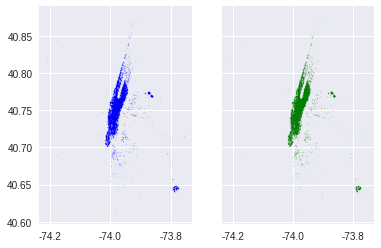

In [47]:
#Plot out training & testing data
#Though we dont have a map of New York City, if we have enough data theoritcially we can plot the map of NYC using the data points
N=10000
city_long_border=(-75,-75)
city_lat_border=(40,40)

fig,ax=plt.subplots(ncols=2,sharex=True, sharey=True)
ax[0].scatter(train_data['pickup_longitude'].values[:N],
             train_data['pickup_latitude'].values[:N],
             color='blue',s=1,label='train',alpha=0.1)

# Where s=1, suggests that it is a one dimensional graph 
ax[1].scatter(train_data['pickup_longitude'].values[:N],
             train_data['pickup_latitude'].values[:N],
             color='green',s=1,label='test',alpha=0.1)
              
plt.show()



**We actually made manhattan using the data points**

**On the left is our training data and on the right is our testing data**

# This is what manhattan really looks like on world map

![alt text](https://static.vecteezy.com/system/resources/previews/000/141/713/non_2x/manhattan-map-vector-illustration.png)


In [0]:
#@title
 #Training the model
  feature_names=list(train_data.columns)
  y=train_data['trip_duration'].as_matrix()
  x_train,x_test,y_train,y_test=train_test_split(train_data[feature_names].as_matrix(),y,test_size=0.2,random_state=42)
  
  model=xgb.train('default',train_data)
  
  